# Library installation

In [ ]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.fft import fft
from scipy import signal
import sys
import time
import pickle

#Helper funtions

In [ ]:
def display_raw_emg(df: pd.DataFrame, subject: int, channel: int, adl: int):
    """
    Displays a single raw EMG signal with respect to time
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            26 activities of daily living (ADL) and 7 surface electrodes.
        subject (int): The human subject [1 - 22]
        channel (int): The source electrode [1 - 7]
        adl (int): Activity of daily living [1 - 26]
    """

    row = raw_data.loc[(raw_data['subject'] == subject) & (raw_data['ADL'] == adl)]
    time = row['time'].values[0]
    raw_emg = row['raw_emg'].values[0][:, channel]
    sns.lineplot(x=time, y=raw_emg)
    plt.xlabel('time')
    plt.ylabel('Raw EMG signal ')
    plt.title(f'subject: {subject}, Muscle: {channel}, ADL: {adl}')
    plt.show()

def display_one_signal(x_vector, y_vector, x_title = None, y_title = None, figure_title=None):
    sns.lineplot(x=x_vector, y=y_vector)

    if(x_title is not None and y_title is not None and figure_title is not None):
      plt.xlabel(x_title)
      plt.ylabel(y_title)
      plt.title(figure_title)
      plt.xscale('log')
    plt.show()

def select_data(df: pd.DataFrame, adl: list, channel_list: list):
    """
    organizes the data, and returns a dataframe containing only the wanted combination of adl and subjects
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            26 activities of daily living (ADL) and 7 surface electrodes.
        adl: a list of selected activities of daily living
        channels: a list of selected source electrodes

    Returns:
        selected_data: A dataframe with the subject ID and the raw emg signals
                for each selected channel
        labels: a label dataframe containing the ADLs
    """
    # select the wanted ADLs
    selected_data = df[df['ADL'].isin(adl)]

    # duplicate the emg columns
    for c in channel_list:
        selected_data = pd.concat([selected_data, selected_data['raw_emg'].rename(f'emg_channel_{c + 1}')], axis=1)

    # only keep the wanted channel in every column
    for sample in range(len(selected_data)):
        for c in channel_list:          
            selected_data[f'emg_channel_{c + 1}'].values[sample] = selected_data[f'emg_channel_{c + 1}'].values[sample][:, c]
    label_vec = selected_data[['ADL']]  # double [] to make it a DataFrame and not a Series

    # we don't need  the label column and the raw_emg column
    selected_data = selected_data.drop(columns=['ADL', 'raw_emg'])
    # todo: feature matrix (encoded) add a column for every emg channel

    return selected_data, label_vec




# Load the data and display example


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sys.path.insert(0,'/content/drive/MyDrive/projet_EMG')

In [ ]:
from feature_extraction import *

In [ ]:
raw_data = pd.read_pickle('/content/drive/MyDrive/projet_EMG/data.pkl')
data = raw_data.copy()

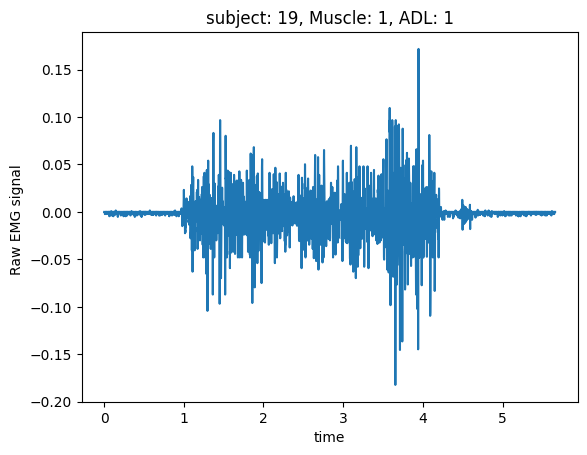

In [ ]:
# Select the subject and the activity of daily life to display
subject = 19
channel = 1
adl = 1
display_raw_emg(data, subject, channel, adl)

# select features #example
adl_list = [1, 2]
channel_list = [0, 1, 2]
selected_data, labels = select_data(data, adl_list, channel_list)

#Select EMG channels and activities of daily life (ADL)

In [ ]:
adls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
channels = [0, 1, 2, 3, 4, 5, 6]
all_data, all_lbl = select_data(data, adls, channels)
print('columns:',all_data.columns)
print('all data shape:', all_data.shape)
print('labels shape:', all_lbl.shape)

columns: Index(['subject', 'time', 'emg_channel_1', 'emg_channel_2', 'emg_channel_3',
       'emg_channel_4', 'emg_channel_5', 'emg_channel_6', 'emg_channel_7'],
      dtype='object')
all data shape: (572, 9)
labels shape: (572, 1)


# Normalization
We only normalize across individuals for the same muscle, to have comparable signals for every EMG channel

In [ ]:
def normalization_across_channels(df:pd.DataFrame):
  """
    Normalizes the EMG signals across different individuals for the same muscle
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            the selected  activities of daily living (ADL) (1 to 26) and selected surface electrodes 1 to 7).
        
    """
  # 1. copy the dataframe:
  normalized_df = df.copy()

  # 3 compute the max for every muscle across individuals
  
  for emg_channel in df.columns[2:]: #every emg channel column
    max_amplitude = 0
    for sample in df.index:
      temp_max = np.max(df[emg_channel][sample])
      if temp_max > max_amplitude:
        max_amplitude = temp_max

    # after computing the max across all samples for 1 emg_channel, we loop again across samples and normalize 
    for sample in df.index:
      normalized_df[emg_channel][sample] = normalized_df[emg_channel][sample]/max_amplitude


  return normalized_df

Apply on all data:

In [ ]:
all_data_normalized = normalization_across_channels(all_data)
print('columns:',all_data_normalized.columns)
print('all data normalized shape:', all_data_normalized.shape)
print('labels shape:', all_lbl.shape)

<ipython-input-8-2ceeaeea32df>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df[emg_channel][sample] = normalized_df[emg_channel][sample]/max_amplitude


columns: Index(['subject', 'time', 'emg_channel_1', 'emg_channel_2', 'emg_channel_3',
       'emg_channel_4', 'emg_channel_5', 'emg_channel_6', 'emg_channel_7'],
      dtype='object')
all data normalized shape: (572, 9)
labels shape: (572, 1)


# Filtrage

# FFT

In [ ]:
def emg_fft(signal, sampling_rate):
    """
   Computes the Fast Fourier Transform on a single signal

    Parameters:
        emg_signal: The EMG signal 
        sampling_rate (float): The sampling rate of the EMG signal
    
    Returns:
        array-like: The FFT of the EMG signal as a one-dimensional array.
    """

    fft = np.fft.fft(signal/len(signal))
    fft_module = 2*np.abs(fft[:int(len(signal)/2)])
    frequencies = np.arange(start=0,stop=sampling_rate,step=2*sampling_rate/len(signal))
    
    return frequencies, fft_module


Display an FFT example

In [ ]:
frequencies, fft_example = emg_fft(signal=selected_data.emg_channel_1.values[4], sampling_rate=1000)

# Filters

Bandpass filtering (20 Hz to 300 Hz)

In [ ]:
def band_pass_filtering(df:pd.DataFrame, lowcut_freq:float, highcut_freq:float, sampling_rate:float, filter_order:int):
  """
    applies a butterworth bandpass filter to the EMG data contained in a dataframe
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            the selected  activities of daily living (ADL) (1 to 26) and selected surface electrodes 1 to 7).
        lowcut_freq : the frequency for the highpass
        highcut_freq : the frequency for the lowpass
        sampling_rate: the sampling rate of the data
        filter order (int) : the order of the butterworth filter to apply

    """
  # 1. insure datatype
  lowcut_freq = float(lowcut_freq)
  hightcut_freq = float(highcut_freq)
  sampling_rate = float(sampling_rate)

  # 2. copy the dataframe:
  filtered_df = df.copy()

  # 3 compute the filter output
  b,a = signal.butter(filter_order, [lowcut_freq, highcut_freq], btype='bandpass', analog=False,fs=sampling_rate, output='ba')

  # 4. for every emg_channel in every sample, filter the signal
  for sample in df.index:
    for emg_channel in df.columns[2:]: #every emg channel column
      filtered_df[emg_channel][sample] = signal.filtfilt(b, a, filtered_df[emg_channel][sample])

  return filtered_df



Apply the band-pass filter on all the data (previously normalized).
Low cut frequency: 20 Hz
High cut frequency : 300 Hz

In [ ]:
# apply the filter
sampling_rate = 1000
lowcut_freq = float(20.0) 
highcut_freq = float(300.0)
filter_order = 4 

filtered_df = band_pass_filtering(all_data_normalized,lowcut_freq, highcut_freq, sampling_rate, filter_order)
print('columns:',filtered_df.columns)
print('all data normalized shape:', filtered_df.shape)
print('labels shape:', all_lbl.shape)

<ipython-input-13-76b853331ee1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[emg_channel][sample] = signal.filtfilt(b, a, filtered_df[emg_channel][sample])


columns: Index(['subject', 'time', 'emg_channel_1', 'emg_channel_2', 'emg_channel_3',
       'emg_channel_4', 'emg_channel_5', 'emg_channel_6', 'emg_channel_7'],
      dtype='object')
all data normalized shape: (572, 9)
labels shape: (572, 1)


Display an example:

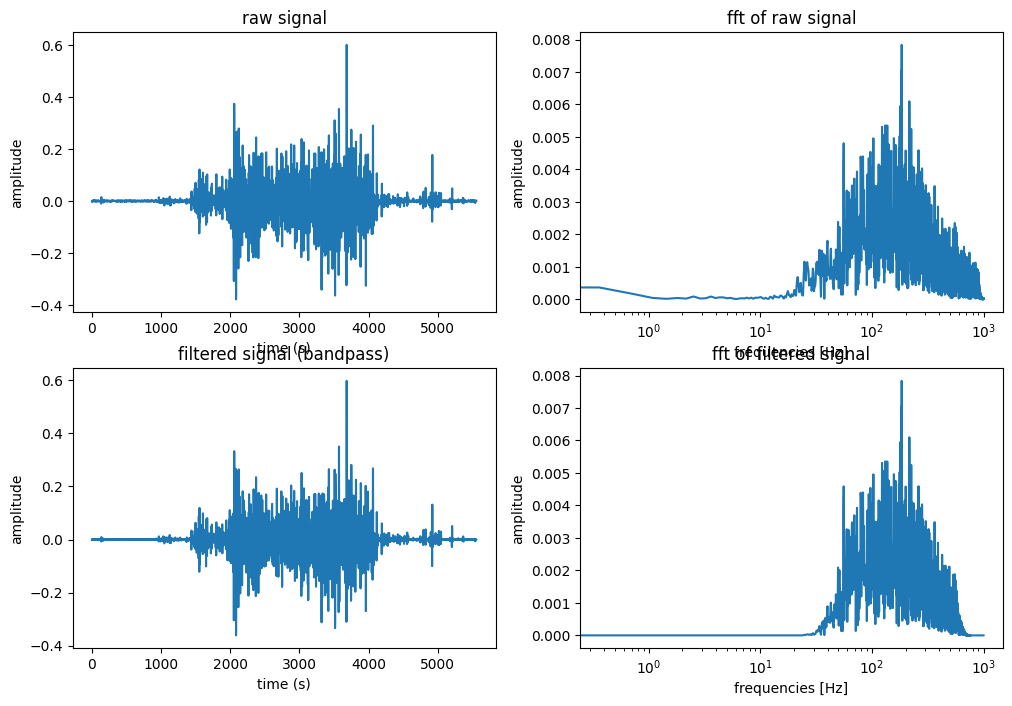

In [ ]:
frequencies, fft_sig = emg_fft(signal=all_data_normalized.emg_channel_1.values[4], sampling_rate=sampling_rate)
frequencies_filtered, fft_sig_filtered = emg_fft(filtered_df.emg_channel_1.values[4], sampling_rate)

plt.rcParams["figure.figsize"] = (12, 8) # Définit la taille des figures à afficher
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(all_data_normalized.emg_channel_1.values[4])
axs[0, 0].set_title('raw signal')
axs[0, 0].set_xlabel('time (s)')
axs[0, 0].set_ylabel('amplitude')

axs[0, 1].plot(frequencies, fft_sig)
axs[0, 1].set_xscale('log')
axs[0, 1].set_title('fft of raw signal')
axs[0, 1].set_xlabel('frequencies [Hz]')
axs[0, 1].set_ylabel('amplitude')

axs[1, 0].plot(filtered_df.emg_channel_1.values[4])
axs[1, 0].set_title('filtered signal (bandpass)')
axs[1, 0].set_xlabel('time (s)')
axs[1, 0].set_ylabel('amplitude')


axs[1, 1].plot(frequencies_filtered, fft_sig_filtered)
axs[1, 1].set_xscale('log')
axs[1, 1].set_title('fft of filtered signal')
axs[1, 1].set_xlabel('frequencies [Hz]')
axs[1, 1].set_ylabel('amplitude')
plt.show()

# Full-wave rectification
 Absolute value of the signal

In [ ]:
def full_wave_rec(df:pd.DataFrame):
  """
    Rectifies the EMG signals by computing the absolute value
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            the selected  activities of daily living (ADL) (1 to 26) and selected surface electrodes 1 to 7).
        
    """
  # 1. copy the dataframe:
  positive_data = df.copy()

  # 3 compute the max for every muscle across individuals
  
  for emg_channel in df.columns[2:]: #every emg channel column
    for sample in df.index:
      positive_data[emg_channel][sample] = np.abs(positive_data[emg_channel][sample])


  return positive_data

Apply on data

In [ ]:
rectified_fw_data = full_wave_rec(filtered_df)
print('columns:',rectified_fw_data.columns)
print('all data normalized shape:', rectified_fw_data.shape)
print('labels shape:', all_lbl.shape)

<ipython-input-16-3574110bcf81>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data[emg_channel][sample] = np.abs(positive_data[emg_channel][sample])


columns: Index(['subject', 'time', 'emg_channel_1', 'emg_channel_2', 'emg_channel_3',
       'emg_channel_4', 'emg_channel_5', 'emg_channel_6', 'emg_channel_7'],
      dtype='object')
all data normalized shape: (572, 9)
labels shape: (572, 1)


Display an example

Text(0, 0.5, 'amplitude')

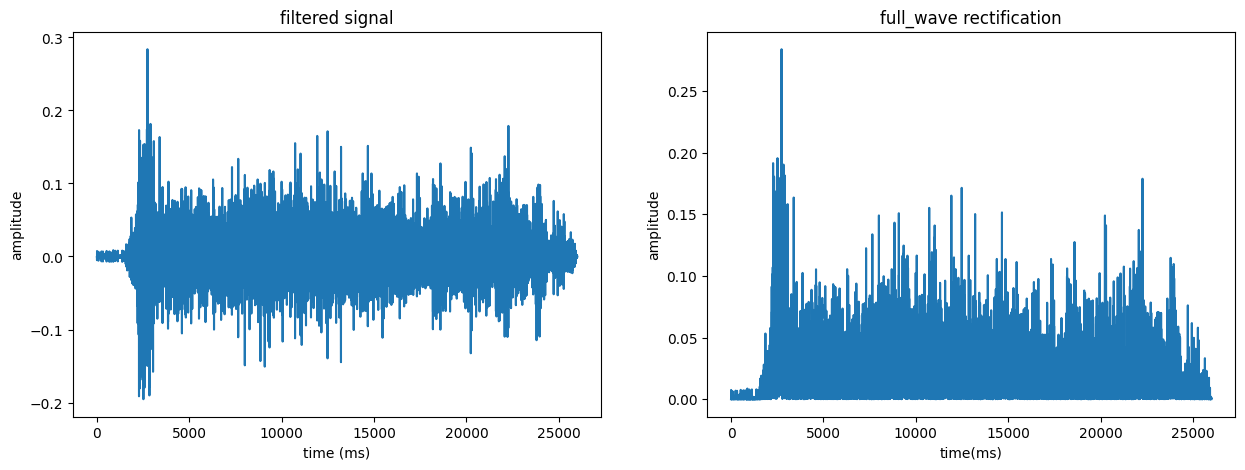

In [ ]:
emg_signal = filtered_df.emg_channel_1.values[20]
rectified_signal = rectified_fw_data.emg_channel_1.values[20] 

plt.rcParams["figure.figsize"] = (15, 5) # Définit la taille des figures à afficher
fig, axs = plt.subplots(1, 2)

axs[0].plot(emg_signal)
axs[0].set_title('filtered signal')
axs[0].set_xlabel('time (ms)')
axs[0].set_ylabel('amplitude')

axs[1].plot(rectified_signal)
axs[1].set_title('full_wave rectification')
axs[1].set_xlabel('time(ms)')
axs[1].set_ylabel('amplitude')

# Padding 
to make all samples of the same length

In [ ]:
def data_resize(df:pd.DataFrame):
    
  """
    resizes all the emg signals to have the same length 
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            the selected  activities of daily living (ADL) (1 to 26) and selected surface electrodes 1 to 7).
    """

  # 1. copy the dataframe:
  resized = df.copy(deep=True)

  # 2 compute the max and min length of all available signals  
  max_length = 1
  min_length = 1000000

  for sample in df.index:
    for emg_channel in df.columns[2:]: #every emg channel column
      sz = len(df[emg_channel][sample])
      if sz > max_length:
        max_length = sz
      elif sz <= min_length:
        min_length = sz
      else:
        pass

  # 3 we loop again to resize
  target_size = max_length

  for sample in df.index:
    for emg_channel in df.columns[2:]: # Every emg channel column
      initial_size = len(df[emg_channel][sample])
      if initial_size < target_size:
        after = target_size - initial_size 
        resized[emg_channel].values[sample] =  np.pad(resized[emg_channel].values[sample], (0, after), mode='constant')

  return resized

Apply and test

In [ ]:
resized_df = data_resize(rectified_fw_data)
print('columns:',resized_df.columns)
print('all data normalized shape:', resized_df.shape)
print('labels shape:', all_lbl.shape)
resized_df['emg_channel_1'][11].shape

columns: Index(['subject', 'time', 'emg_channel_1', 'emg_channel_2', 'emg_channel_3',
       'emg_channel_4', 'emg_channel_5', 'emg_channel_6', 'emg_channel_7'],
      dtype='object')
all data normalized shape: (572, 9)
labels shape: (572, 1)


(33620,)

In [ ]:
resized_df['emg_channel_1'][1].shape

(33620,)

# Feature extraction

The feature extraction function is from an existing library that comoputes 18 different mesures on a single EMG signal array.\

> Input

       One EMG signal :np.array
       Sampling frequency
       Frame size (in ms)
       Overlapping window step (in ms)

> Output

        Feature matrix of shape :[number of features, number of windows]
        Feature names :[list]
source : https://github.com/SebastianRestrepoA/EMG-pattern-recognition

Testing the imported library

In [ ]:
sampling_frequency = 1e3
frame = 500  #(ms)
step = 250   #(ms)

emg_signal = resized_df.emg_channel_1.values[19]

# Biomedical Signal Processing
filtered_signal = resized_df.emg_channel_1.values[19]

channel_name = '_'
# EMG Feature Extraction
emg_features, features_names = features_estimation(filtered_signal, channel_name,
                                                   sampling_frequency, frame, step)

/content/drive/MyDrive/projet_EMG/feature_extraction.py:70: RuntimeWarning: divide by zero encountered in log10
  log_detector.append(np.exp(np.sum(np.log10(np.absolute(x))) / frame))


EMG features were from channel _ extracted successfully


/content/drive/MyDrive/projet_EMG/feature_extraction.py:168: RuntimeWarning: invalid value encountered in double_scalars
  return ULC / UHC
/content/drive/MyDrive/projet_EMG/feature_extraction.py:199: RuntimeWarning: invalid value encountered in double_scalars
  return num / den
/content/drive/MyDrive/projet_EMG/feature_extraction.py:211: RuntimeWarning: invalid value encountered in double_scalars
  errel = (power_total - temp) / power_total
/content/drive/MyDrive/projet_EMG/feature_extraction.py:225: RuntimeWarning: invalid value encountered in double_scalars
  Ea = 100 * np.sum(cA ** 2) / Et
/content/drive/MyDrive/projet_EMG/feature_extraction.py:231: RuntimeWarning: invalid value encountered in double_scalars
  Ed.append(100 * np.sum(cD ** 2) / Et)


In [ ]:
print(emg_features.shape)
print('emg features type:', type(emg_features))
print(features_names)
print(resized_df.emg_channel_1.values[19].shape)
print(emg_features[120]['RMS'])


(18, 133)
emg features type: <class 'pandas.core.frame.DataFrame'>
['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', 'FR', 'MNP', 'TP', 'MNF', 'MDF', 'PKF', 'WENT']
(33620,)
0.0


In [ ]:
print(resized_df.shape)
print(resized_df.info())
print(resized_df.subject[571])
print('columns:',resized_df.columns)
print('all data normalized shape:', resized_df.shape)
print('labels shape:', all_lbl.shape)

(572, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 572 entries, 0 to 571
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subject        572 non-null    uint8 
 1   time           572 non-null    object
 2   emg_channel_1  572 non-null    object
 3   emg_channel_2  572 non-null    object
 4   emg_channel_3  572 non-null    object
 5   emg_channel_4  572 non-null    object
 6   emg_channel_5  572 non-null    object
 7   emg_channel_6  572 non-null    object
 8   emg_channel_7  572 non-null    object
dtypes: object(8), uint8(1)
memory usage: 56.9+ KB
None
22
columns: Index(['subject', 'time', 'emg_channel_1', 'emg_channel_2', 'emg_channel_3',
       'emg_channel_4', 'emg_channel_5', 'emg_channel_6', 'emg_channel_7'],
      dtype='object')
all data normalized shape: (572, 9)
labels shape: (572, 1)


Display the dataframe before feature extraction:

In [ ]:
resized_df.head()

,subject,time,emg_channel_1,emg_channel_2,emg_channel_3,emg_channel_4,emg_channel_5,emg_channel_6,emg_channel_7
0,1,"[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...","[3.383287304216807e-05, 0.00041661041985993847...","[1.5865829479707114e-05, 0.002959598364487127,...","[3.349876280172747e-05, 4.5869857194613363e-05...","[0.000176734292337378, 0.00010237828722540858,...","[7.103074902520962e-05, 0.0002955828716952534,...","[2.3127547295546987e-05, 0.0003980875025961866...","[8.050992902886212e-05, 0.0004674452151259555,..."
1,1,"[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...","[4.0589786146646615e-05, 0.000132124083095067,...","[6.965594394096219e-05, 0.0040839203591818505,...","[2.1041840480878543e-05, 0.0005170012977646081...","[4.623881661367667e-05, 0.0002408512561227592,...","[6.862731701309484e-05, 0.00018340911586090729...","[4.394808319673591e-05, 0.00038544236218442774...","[3.224595003873123e-05, 5.3633134846596366e-05..."
2,1,"[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...","[0.00010893662350375835, 0.0006115743283017761...","[0.00010496382968231275, 0.0031471669853735803...","[2.0785731411493815e-05, 0.0011495743493832775...","[5.344304789192264e-06, 0.0020216136531826102,...","[5.931905794908759e-05, 4.715013881088692e-05,...","[2.5800436189483086e-05, 0.0002102826330401132...","[2.804261463107958e-05, 0.0008073480911211892,..."
3,1,"[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...","[1.895650277400666e-05, 0.000883125829784011, ...","[0.00010877977252175635, 0.0019654471017782286...","[8.441927987599086e-05, 8.40117125179359e-05, ...","[7.851794740468982e-05, 0.0005080611095793019,...","[2.169315741319367e-05, 0.001890283575869325, ...","[1.2060953414999425e-05, 0.0001026480503072208...","[0.00011102587054241051, 0.0002152217240463451..."
4,1,"[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...","[4.63981953437242e-05, 0.0012525814651846645, ...","[0.00017075150853220465, 0.0022771555668865107...","[5.250975763442855e-05, 0.0016619044860708904,...","[0.00010730164730183256, 0.0005471054137593716...","[2.0306410561185074e-05, 0.0004555722785458753...","[1.2659098052032197e-05, 0.0001700000724489084...","[5.608543757734018e-05, 0.001120262747775266, ..."


In [ ]:
def features(df:pd.DataFrame, sampling_freq, window_size_ms, sliding_len_ms):
  """
    extract features from every EMG signal using the code above
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            the selected  activities of daily living (ADL) (1 to 26) and selected surface electrodes 1 to 7).
        sampling_freq : Sampling frequency of the signal
        window_size_ms : the window size in milliseconds
        sliding_len_ms : the overlapping step between consecutive windows in milliseconds
  """
  feature_mat = pd.DataFrame(columns = [df.columns[0]]) 

  #### sliding window parameters

  window_size = int((window_size_ms/1000)*sampling_freq) 
  sliding_len = int((sliding_len_ms/1000)*sampling_freq)

  #use a random signal to set the length
  signal = df.emg_channel_1.values[10] 
  nb_windows = int(np.floor((len(signal)-window_size) / sliding_len)) + 1

  # for every sample:
  # duplicate every sample line into feature_nb lines 
  # for every feature line (sample_i_RMS), we have the window RMSs for channel 1, followed by the ones for channel 2, etc until the last channel
  channel_nb = len(df.columns[2:]) # !!! if the time column is in rectified_fw_data, otherwise change to: [1:]
  feature_nb = 18  ## could be modified


  emg_channel_cols = df.columns[2:] ###!!! if the time column is in rectified_fw_data, otherwise change to: [1:] and if adl is in df, take it into account [1:-1]

  for sample in range(df.shape[0]): ## do not forget the labels 
    feature_mat_per_sample = pd.DataFrame({'subject' : np.repeat(sample+1, feature_nb)})
    for c in range(channel_nb):
      for w in range(nb_windows):
        column_name = f'emg{c+1}_window{w+1}'
        feature_mat_per_sample = feature_mat_per_sample.assign(**{column_name: pd.Series(dtype='float64')})
    # fill it 
    for c in range(channel_nb): # !!! if the time column is in rectified_fw_data, otherwise change to: [1:]
      channel_name ='_'
      emg_features, features_names = features_estimation(df[emg_channel_cols[c]].values[sample], channel_name, sampling_freq, window_size_ms, sliding_len_ms)
      emg_features = emg_features.fillna(0)
      feature_mat_per_sample.iloc[:, c*nb_windows+1:c*nb_windows+nb_windows+1] = emg_features.values
    #maybe add 18 columns to encode for the feature type
    identity_mat = np.identity(feature_nb, dtype=int)
    feature_ohe = pd.DataFrame(identity_mat, columns=features_names)
    feature_mat_per_sample = pd.concat([feature_mat_per_sample, feature_ohe], axis = 1)
    feature_mat = pd.concat([feature_mat, feature_mat_per_sample], axis=0, ignore_index=True)

  return feature_mat

          

In [ ]:
def label_resizing(lbl:pd.DataFrame, feature_nb:int):
  """
    extends the label datafram to fit the feature dataframe rows
    Args:
        df: DataFrame containing the raw emg signals for 22 subjects,
            the selected  activities of daily living (ADL) (1 to 26) and selected surface electrodes 1 to 7).
        feature_nb : the number of features extracted in the previous step
  """
  new_lbl = pd.DataFrame(columns=all_lbl.columns) 

  # for every sample:

  for sample in range(all_lbl.shape[0]):
    lbl_per_sample = pd.DataFrame({'ADL' : np.repeat((all_lbl['ADL'][sample])-1, feature_nb)})  ## here i transform the adl labels to start from 0 instead of 1
    new_lbl = pd.concat([new_lbl, lbl_per_sample], axis=0, ignore_index=True)

  return new_lbl

Apply the feature extraction and label expansion

In [ ]:
# window parameters
sampling_freq = 1000
window_size_ms = 500
sliding_len_ms = 250

time_start = time.time()
feature_mat = features(resized_df, sampling_freq, window_size_ms, sliding_len_ms)
time_end = time.time()

total_time = (time_end - time_start)/60
print(f"feature extraction time: {total_time:.2f} seconds")


In [ ]:
labels = label_resizing(all_lbl, feature_nb=18)

In [ ]:
print('features shape:', feature_mat.shape)
print('labels shape:', labels.shape)

features shape: (10296, 950)
labels shape: (10296, 1)


## save the feature matrix and labels to csv 
to avoid running time (30 min)

In [ ]:
feature_mat.to_csv('/content/drive/MyDrive/projet_EMG/all_features_all_ADL.csv', index=False)
print('Feature DataFrame saved in CSV format.')

Feature DataFrame saved in CSV format.


In [ ]:
labels.to_csv('/content/drive/MyDrive/projet_EMG/all_labels_all_ADL.csv', index=False)
print('Label DataFrame saved in CSV format.')

Label DataFrame saved in CSV format.


# Split dataset

In [ ]:
def data_splitting(X: pd.DataFrame, y: pd.DataFrame, train_ratio: float, val_ratio: float, test_ratio: float):
    """
    Splits data into train, test and validation according to the wanted ratios
    Args:
        X: Feature DataFrame
        y: Label DataFrame
        train_ratio: ratio of data to be in the training dataset
        val_ratio: ratio of data to be in the validation dataset
        test_ratio: ratio of data to be in the test dataset

    Returns:
        split dataset (train val and test)
    """

    X_temp, X_test, y_temp, y_test = train_test_split(X.values, y.values, test_size=test_ratio, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio / (val_ratio + train_ratio),
                                                      random_state=2)
    X_train = X_train.astype('float')
    X_val = X_val.astype('float')
    X_test = X_test.astype('float')


    y_train = y_train.astype('int')
    y_val = y_val.astype('int')
    y_test = y_test.astype('int')
 
    y_train = y_train.ravel()
    y_val = y_val.ravel()
    y_test = y_test.ravel()

    y_train = y_train.astype('int')
    y_val = y_val.astype('int')
    y_test = y_test.astype('int')

    return X_train, X_val, X_test, y_train, y_val, y_test

Load data to avoir re-runing everything

In [ ]:
feature_mat = pd.read_csv('/content/drive/MyDrive/projet_EMG/all_features_all_ADL.csv')
labels = pd.read_csv('/content/drive/MyDrive/projet_EMG/all_labels_all_ADL.csv')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test =  data_splitting(X=feature_mat, y=labels, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

save the split datasets

In [ ]:
np.savetxt('/content/drive/MyDrive/projet_EMG/split_datasets/train/X_train.csv', X_train, delimiter=',')
np.savetxt('/content/drive/MyDrive/projet_EMG/split_datasets/train/y_train.csv', y_train, delimiter=',')
print('X_train DataFrame saved in CSV format.')
print('y_train DataFrame saved in CSV format.')

np.savetxt('/content/drive/MyDrive/projet_EMG/split_datasets/validation/X_val.csv', X_val, delimiter=',')
np.savetxt('/content/drive/MyDrive/projet_EMG/split_datasets/validation/y_val.csv', y_val, delimiter=',')
print('X_val DataFrame saved in CSV format.')
print('y_val DataFrame saved in CSV format.')

np.savetxt('/content/drive/MyDrive/projet_EMG/split_datasets/test/X_test.csv', X_test, delimiter=',')
np.savetxt('/content/drive/MyDrive/projet_EMG/split_datasets/test/y_test.csv', y_test, delimiter=',')
print('X_test DataFrame saved in CSV format.')
print('y_test DataFrame saved in CSV format.')

load the 3 split datasets

In [ ]:
X_train = np.loadtxt('/content/drive/MyDrive/projet_EMG/split_datasets/train/X_train.csv', delimiter=',')
y_train = np.loadtxt('/content/drive/MyDrive/projet_EMG/split_datasets/train/y_train.csv', delimiter=',')

X_val = np.loadtxt('/content/drive/MyDrive/projet_EMG/split_datasets/validation/X_val.csv', delimiter=',')
y_val = np.loadtxt('/content/drive/MyDrive/projet_EMG/split_datasets/validation/y_val.csv', delimiter=',')

X_test = np.loadtxt('/content/drive/MyDrive/projet_EMG/split_datasets/test/X_test.csv', delimiter=',')
y_test = np.loadtxt('/content/drive/MyDrive/projet_EMG/split_datasets/test/y_test.csv', delimiter=',')


Check shapes, types and nan values:

In [ ]:
print('X_train type:', type(X_train), 'of shape:', X_train.shape, '| NaN values:', np.isnan(X_train.any()), "| finite values:", np.isfinite(X_train.all()), "| data type:", X_train.dtype)
print('X_val type  :', type(X_val), 'of shape:', X_val.shape, '| NaN values:', np.isnan(X_val.any()), "| finite values:", np.isfinite(X_val.all()), "| data type:", X_val.dtype)
print('X_test type  :', type(X_test), 'of shape:', X_test.shape, '| NaN values:', np.isnan(X_test.any()), "| finite values:", np.isfinite(X_test.all()), "| data type:", X_test.dtype)
print('y_train type:', type(y_train), 'of shape:', y_train.shape, ' NaN values:', np.isnan(y_train.any()), "| finite values:", np.isfinite(y_train.all()), "|data type:", y_train.dtype)
print('y_val type  :', type(y_val), 'of shape:', y_val.shape, ' NaN values:', np.isnan(y_val.any()), "| finite values:", np.isfinite(y_val.all()), "|data type:", y_val.dtype)
print('y_test type  :', type(y_test), 'of shape:', y_test.shape, ' NaN values:', np.isnan(y_test.any()), "| finite values:", np.isfinite(y_test.all()), "|data type:", y_test.dtype)

X_train type: <class 'numpy.ndarray'> of shape: (6177, 950) | NaN values: False | finite values: True | data type: float64
X_val type  : <class 'numpy.ndarray'> of shape: (2059, 950) | NaN values: False | finite values: True | data type: float64
X_test type  : <class 'numpy.ndarray'> of shape: (2060, 950) | NaN values: False | finite values: True | data type: float64
y_train type: <class 'numpy.ndarray'> of shape: (6177,)  NaN values: False | finite values: True |data type: int64
y_val type  : <class 'numpy.ndarray'> of shape: (2059,)  NaN values: False | finite values: True |data type: int64
y_test type  : <class 'numpy.ndarray'> of shape: (2060,)  NaN values: False | finite values: True |data type: int64


# Training

helper functions

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def fit_and_predict(model, x_fit: np.ndarray, y_fit: np.ndarray, x_pred: np.ndarray, y_true: np.ndarray) -> float:
    """ Fits a sklearn model using x_fit and y_fit and predicts the labels for x_pred. Returns the F1 score between the model predictions and y_pred

    Args:
        model: sklearn model
        x_fit (np.ndarray): the samples to fit
        y_fit (np.ndarray): the labels to fit
        x_pred (np.ndarray): the samples to predict
        y_true (np.ndarray): the ground truth labels

    Returns:
        f1_score (float): F1 score between the model predictions for x_pred and the ground truth (y_pred)
    """
    model.fit(x_fit, y_fit )
    y_pred_model = model.predict(x_pred)
    f1 = f1_score(y_true, y_pred_model, average='micro') 
    acc = accuracy_score(y_true, y_pred_model)
    print('Training f1 score is:', f1)
    print('Training Accuracy:',acc*100,"%")  

    return f1, acc


from sklearn.model_selection import RandomizedSearchCV
def hyper_parameter_tuning(model, distribution:dict, selected_features:np.array, labels:np.array):
    """ Searches for the best hyperparameter combinations

      Args:
          model: sklearn model
          distribution (dict): the hyperparameter values to try
          selected_features (np.ndarray): the samples to predict
          labels (np.ndarray): the ground truth labels

      Returns:
          rs.best_params_ : The best value for every hyper-parameter in the dictionnary
          rs.best_score_  : the corresponding score
      """

    rs = RandomizedSearchCV(model, distribution, cv=3)
    rs.fit(selected_features, labels)
    print('Best parameters: ', rs.best_params_)
    print('Best score: ', rs.best_score_)
    return rs.best_params_, rs.best_score_

##SVM

In [ ]:
from sklearn.svm import LinearSVC


model = LinearSVC()

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
svm_path = "/content/drive/MyDrive/projet_EMG/trained_models/svm.pickle"
pickle.dump(model, open(svm_path, "wb"))

Training f1 score is: 0.3190869354055367
Training Accuracy: 31.908693540553667 %
training time: 3.01 minutes
___________________________________________________
Validation f1 score is: 0.19621175327829043
Validation Accuracy: 19.621175327829043 %


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


load the model

In [ ]:
loaded_svm_model = pickle.load(open(svm_path, "rb"))
 # verify (delete?)
val_pred = loaded_svm_model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  


___________________________________________________
Validation f1 score is: 0.19621175327829043
Validation Accuracy: 19.621175327829043 %


### hyperparameter tuning

In [ ]:
distributions = {'C': [0.1, 1, 10, 100], 
              'multi_class':['ovr', 'crammer_singer'],
              'max_iter' : [100, 1000, 10000]} 

time_start = time.time()
svm_best_params, svm_best_score = hyper_parameter_tuning(LinearSVC(), distribution = distributions, selected_features=X_val, labels=y_val)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

print("best parameters: ", svm_best_params)
print("best score: ", svm_best_score)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

Best parameters:  {'multi_class': 'crammer_singer', 'max_iter': 10000, 'C': 0.1}
Best score:  0.3424085791521849
training time: 201.33 minutes
best parameters:  {'multi_class': 'crammer_singer', 'max_iter': 10000, 'C': 0.1}
best score:  0.3424085791521849


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


retrain with best hyperparameters

In [ ]:
model = LinearSVC(multi_class = 'crammer_singer', max_iter=10000, C=0.1)

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
tuned_svm_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_svm.pickle"
pickle.dump(model, open(tuned_svm_path, "wb"))

Training f1 score is: 0.730127893799579
Training Accuracy: 73.01278937995791 %
training time: 62.85 minutes
___________________________________________________
Validation f1 score is: 0.5293831957260806
Validation Accuracy: 52.93831957260806 %


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


test on untouched data:

In [ ]:
tuned_svm_model = pickle.load(open(tuned_svm_path, "rb"))
#test:
test_pred = tuned_svm_model.predict(X_test)
f1_test = f1_score(y_test, test_pred, average='micro')
acc = accuracy_score(y_test, test_pred)

print("___________________________________________________")

print('Test f1 score is:', f1_test)
print('Test Accuracy:',acc*100,"%")  

___________________________________________________
Test f1 score is: 0.5325242718446602
Test Accuracy: 53.25242718446602 %


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
rnd_forest_path = "/content/drive/MyDrive/projet_EMG/trained_models/rnd_forest.pickle"
pickle.dump(model, open(rnd_forest_path, "wb"))

Training f1 score is: 1.0
Training Accuracy: 100.0 %
training time: 0.18 minutes
___________________________________________________
Validation f1 score is: 0.47353084021369596
Validation Accuracy: 47.3530840213696 %


load the model

In [ ]:
loaded_rnd_forest_model = pickle.load(open(rnd_forest_path, "rb"))
 # verify (delete?)
val_pred = loaded_rnd_forest_model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  


___________________________________________________
Validation f1 score is: 0.47353084021369596
Validation Accuracy: 47.3530840213696 %


### hyperparameter tuning

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False] 

distributions = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'bootstrap': bootstrap}

rnd_foorest_best_params, rnd_forest_best_score = hyper_parameter_tuning(RandomForestClassifier(), distribution=distributions, selected_features=X_val, labels=y_val)

Best parameters:  {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
Best score:  0.3375466634980047


retrain with best hyperparameters

In [ ]:
model = RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=80, bootstrap=False)

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
tuned_rnd_forest_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_rnd_forest.pickle"
pickle.dump(model, open(tuned_rnd_forest_path, "wb"))

Training f1 score is: 0.939290917921321
Training Accuracy: 93.9290917921321 %
training time: 1.29 minutes
___________________________________________________
Validation f1 score is: 0.4958717824186498
Validation Accuracy: 49.58717824186498 %


test on untouched data

In [ ]:
tuned_rnd_forest_model = pickle.load(open(tuned_rnd_forest_path, "rb"))
#test:
test_pred = tuned_rnd_forest_model.predict(X_test)
f1_test = f1_score(y_test, test_pred, average='micro')
acc = accuracy_score(y_test, test_pred)

print("___________________________________________________")
print('Test f1 score is:', f1_test)
print('Test Accuracy:',acc*100,"%")  

___________________________________________________
Test f1 score is: 0.4975728155339806
Test Accuracy: 49.75728155339806 %


## CatBoost Classifier

In [ ]:
!pip install catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=False)

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  


#save model
cbc_path = "/content/drive/MyDrive/projet_EMG/trained_models/cbc.pickle"
pickle.dump(model, open(cbc_path, "wb"))

Training f1 score is: 0.9004371053909664
Training Accuracy: 90.04371053909665 %
training time: 90.96 minutes
___________________________________________________
Validation f1 score is: 0.6138902379796017
Validation Accuracy: 61.38902379796017 %


load the model

In [ ]:
loaded_cbc_model = pickle.load(open(cbc_path, "rb"))
 # verify (delete?)
val_pred = loaded_cbc_model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  


___________________________________________________
Validation f1 score is: 0.6138902379796017
Validation Accuracy: 61.38902379796017 %


### hyperparameter tuning

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
distributions = dict(
    learning_rate=np.arange(0.05, 0.15, 0.05),
    depth=np.arange(8, 15, 3),
    l2_leaf_reg=np.arange(1, 10, 1),
)

cbc_best_params, cbc_best_score = hyper_parameter_tuning(CatBoostClassifier(verbose=False), distribution = distributions, selected_features=X_val, labels=y_val)


retrain with hyperparameters

In [ ]:
model = CatBoostClassifier(    )

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
tuned_cbc_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_cbc.pickle"
pickle.dump(model, open(tuned_cbc_path, "wb"))

test on untouched data

In [ ]:
tuned_cbc_model = pickle.load(open(tuned_cbc_path, "rb"))
#test:
test_pred = tuned_cbc_model.predict(X_test)
f1_test = f1_score(y_test, test_pred, average='micro')
acc = accuracy_score(y_test, test_pred)

print("___________________________________________________")
print('Test f1 score is:', f1_test)
print('Test Accuracy:',acc*100,"%")  

test the basic catbooston untouched data

In [ ]:
cbc_path = "/content/drive/MyDrive/projet_EMG/trained_models/cbc.pickle"
cbc_model = pickle.load(open(cbc_path, "rb"))
#test:
test_pred = cbc_model.predict(X_test)
f1_test = f1_score(y_test, test_pred, average='micro')
acc = accuracy_score(y_test, test_pred)

print("___________________________________________________")
print('Test f1 score is:', f1_test)
print('Test Accuracy:',acc*100,"%")  

___________________________________________________
Test f1 score is: 0.6043689320388349
Test Accuracy: 60.43689320388349 %


## XGB Classifier

In [ ]:
from xgboost import XGBClassifier 

model = XGBClassifier()

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
xgb_path = "/content/drive/MyDrive/projet_EMG/trained_models/xgb.pickle"
pickle.dump(model, open(xgb_path, "wb"))

Training f1 score is: 1.0
Training Accuracy: 100.0 %
training time: 24.07 minutes
___________________________________________________
Validation f1 score is: 0.9252064108790675
Validation Accuracy: 92.52064108790675 %


load the model

In [ ]:
loaded_xgb_model = pickle.load(open(xgb_path, "rb"))
 # verify (delete?)
val_pred = loaded_xgb_model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  


### hyperparameter tuning

In [ ]:
distributions = dict(
    #iterations=np.arange(100, 2000, 500),
    learning_rate=[0.1 , 0.01 , 0.001],
    max_depth=[3 , 5 , 7],
    colsample_bytree = np.arange(0.2 , 1.2 , 0.5),
    subsample = np.arange(0.7 , 1 , 0.1),
    gamma = [ 0 , 1 , 5], 
    n_estimators = np.arange( 50 , 150 , 50)
)

xgb_best_params, xgb_best_score = hyper_parameter_tuning(XGBClassifier(), distribution = distributions, selected_features=X_val, labels=y_val)
#takes 53 min

[07:25:26] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:26:49] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:28:31] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:29:55] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:30:50] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:31:48] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:32:45] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:34:14] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:35:47] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:37:17] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:40:19] WARNING: ../src/learner.cc:767: 
Parameters: { "iterations" } are not used.

[07:43:25] WARNING: ../src/learn

retrain with hyperparameteres

In [ ]:
model = XGBClassifier(subsample= 0.7999999999999999, n_estimators=50, max_depth=5, learning_rate=0.1, gamma=1, colsample_bytree=0.7)

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
tuned_xgb_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_xgb.pickle"
pickle.dump(model, open(tuned_xgb_path, "wb"))

Training f1 score is: 0.8870001618908856
Training Accuracy: 88.70001618908856 %
training time: 6.34 minutes
___________________________________________________
Validation f1 score is: 0.5220981058766392
Validation Accuracy: 52.20981058766392 %


test on untouched data

In [ ]:
tuned_xgb_model = pickle.load(open(tuned_xgb_path, "rb"))
#test:
test_pred = tuned_xgb_model.predict(X_test)
f1_test = f1_score(y_test, test_pred, average='micro')
acc = accuracy_score(y_test, test_pred)

print("___________________________________________________")
print('Test f1 score is:', f1_test)
print('Test Accuracy:',acc*100,"%")  

___________________________________________________
Test f1 score is: 0.525242718446602
Test Accuracy: 52.5242718446602 %


test the basic xgb model on untouched data

In [ ]:
xgb_path = "/content/drive/MyDrive/projet_EMG/trained_models/xgb.pickle"
xgb_model = pickle.load(open(xgb_path, "rb"))
#test:
test_pred = xgb_model.predict(X_test)
f1_test = f1_score(y_test, test_pred, average='micro')
acc = accuracy_score(y_test, test_pred)

print("___________________________________________________")
print('Test f1 score is:', f1_test)
print('Test Accuracy:',acc*100,"%")  

___________________________________________________
Test f1 score is: 0.9179611650485436
Test Accuracy: 91.79611650485437 %


## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
mlp_path = "/content/drive/MyDrive/projet_EMG/trained_models/mlp.pickle"
pickle.dump(model, open(mlp_path, "wb"))

Training f1 score is: 0.48971992876801035
Training Accuracy: 48.97199287680103 %
training time: 0.94 minutes
___________________________________________________
Validation f1 score is: 0.2850898494414764
Validation Accuracy: 28.50898494414764 %


load the model

In [ ]:
loaded_mlp_model = pickle.load(open(mlp_path, "rb"))
 # verify (delete?)
val_pred = loaded_mlp_model.predict(X_val)
f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  


___________________________________________________
Validation f1 score is: 0.2850898494414764
Validation Accuracy: 28.50898494414764 %


### hyperparameter tuning

In [ ]:
distributions = dict(
    hidden_layer_sizes=[(2 ** i,) for i in range(1, 10)],
    activation=["identity", "logistic", "tanh", "relu"],
    solver=["lbfgs", "sgd", "adam"],
    alpha=np.arange(0.0001, 0.1, 0.0001),
    learning_rate=["constant", "invscaling", "adaptive"],
    learning_rate_init=np.arange(0.0001, 0.1, 0.0001),
)


mlp_best_params, mlp_best_score = hyper_parameter_tuning(MLPClassifier(), distribution = distributions, selected_features=X_val, labels=y_val)

print(mlp_best_params)
print(mlp_best_score)

#takes 5 min

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Best parameters:  {'solver': 'lbfgs', 'learning_rate_init': 0.0164, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (256,), 'alpha': 0.052300000000000006, 'activation': 'identity'}
Best score:  0.17582325090568562
{'solver': 'lbfgs', 'learning_rate_init': 0.0164, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (256,), 'alpha': 0.052300000000000006, 'activation': 'identity'}
0.17582325090568562


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


retrain with hyperparameters

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs', learning_rate_init=0.01,learning_rate='adaptive', hidden_layer_sizes=256, alpha=0.05, activation='identity')
# train the model
time_start = time.time()
f1_train, acc_train = fit_and_predict(model, X_train, y_train, X_train, y_train)
time_end = time.time()
total_time = (time_end - time_start)/60
print(f"training time: {total_time:.2f} minutes")

# compute the eval metrics on the validation dataset
val_pred = model.predict(X_val)

f1_val = f1_score(y_val, val_pred, average='micro')
acc = accuracy_score(y_val, val_pred)

print("___________________________________________________")

print('Validation f1 score is:', f1_val)
print('Validation Accuracy:',acc*100,"%")  

#save model
tuned_mlp_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_mlp.pickle"
pickle.dump(model, open(tuned_mlp_path, "wb"))

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Training f1 score is: 0.25967298041120285
Training Accuracy: 25.967298041120284 %
training time: 1.53 minutes
___________________________________________________
Validation f1 score is: 0.19912578921806703
Validation Accuracy: 19.912578921806702 %


test on untouched data

In [ ]:
tuned_mlp_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_mlp.pickle"
tuned_mlp_model = pickle.load(open(tuned_mlp_path, "rb"))
#test:
test_pred = tuned_mlp_model.predict(X_test)
f1_test = f1_score(y_test, test_pred, average='micro')
acc = accuracy_score(y_test, test_pred)

print("___________________________________________________")
print('Test f1 score is:', f1_test)
print('Test Accuracy:',acc*100,"%")  

___________________________________________________
Test f1 score is: 0.1990291262135922
Test Accuracy: 19.902912621359224 %


# Result analysis

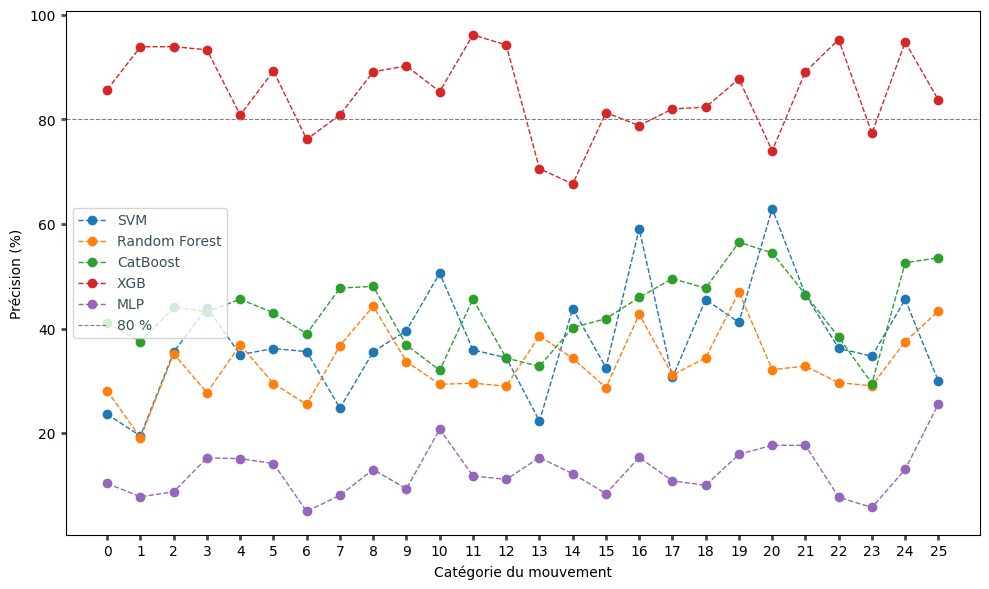

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Define the predicted outputs for each classifier
tuned_svm_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_svm.pickle"
tuned_rnd_forest_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_rnd_forest.pickle"
cbc_path = "/content/drive/MyDrive/projet_EMG/trained_models/cbc.pickle"
xgb_path = "/content/drive/MyDrive/projet_EMG/trained_models/xgb.pickle"
tuned_mlp_path = "/content/drive/MyDrive/projet_EMG/trained_models/tuned_mlp.pickle"


tuned_svm_model = pickle.load(open(tuned_svm_path, "rb"))
tuned_rnd_forest_model = pickle.load(open(tuned_rnd_forest_path, "rb"))
cbc_model = pickle.load(open(cbc_path, "rb"))    
xgb_model = pickle.load(open(xgb_path, "rb"))    
tuned_mlp_model = pickle.load(open(tuned_mlp_path, "rb"))


svm_preds = tuned_svm_model.predict(X_test)
rnd_forest_preds = tuned_rnd_forest_model.predict(X_test)
cbc_preds = cbc_model.predict(X_test).ravel()
xgb_preds = xgb_model.predict(X_test)
mlp_preds = tuned_mlp_model.predict(X_test)



def compute_accuracy_per_category(y_preds, y_test):
  cm = confusion_matrix(y_test, y_preds)
  nb_classes = cm.shape[0]
  accuracy = np.zeros(nb_classes)
  for i in range(nb_classes):
      TP_i = cm[i, i]
      FP_i = np.sum(cm[:, i]) - TP_i
      FN_i = np.sum(cm[i, :]) - TP_i
      accuracy[i] = 100* TP_i / (TP_i + FP_i + FN_i)
  return accuracy

categories = np.linspace(0, 25, 26, endpoint=True, dtype=int)

svm_acc = compute_accuracy_per_category(svm_preds, y_test)
rnd_forest_acc = compute_accuracy_per_category(rnd_forest_preds, y_test)
cbc_acc = compute_accuracy_per_category(cbc_preds, y_test)
xgb_acc = compute_accuracy_per_category(xgb_preds, y_test)
mlp_acc = compute_accuracy_per_category(mlp_preds, y_test)

# Plot the accuracies for every class for each classifier
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(categories, svm_acc, linestyle='--', linewidth=1, marker='o', label='SVM')
ax.plot(categories, rnd_forest_acc, linestyle='--', linewidth=1, marker='o', label='Random Forest')
ax.plot(categories, cbc_acc, linestyle='--', linewidth=1, marker='o', label='CatBoost')
ax.plot(categories, xgb_acc, linestyle='--', linewidth=1, marker='o', label='XGB')
ax.plot(categories, mlp_acc, linestyle='--', linewidth=1, marker='o', label='MLP')

ax.axhline(y=80, linestyle='--',linewidth=0.8, color='gray', label='80 %')

ax.tick_params(axis='both', which='both', color='#36525C', width=2)

ax.set_xticks(categories)
ax.set_xticklabels(categories)
ax.set_xlabel('Catégorie du mouvement')
ax.set_ylabel('Précision (%)')

legend = ax.legend(loc='center left')
for text in legend.get_texts():
    text.set_color('#36525C')

plt.tight_layout()
#plt.show()

fig = plt.gcf()
#fig.patch.set_alpha(0.0)
plt.savefig('/content/drive/MyDrive/projet_EMG/graph.svg', format='svg', transparent=True)


display 5 raw signals (for the poster)

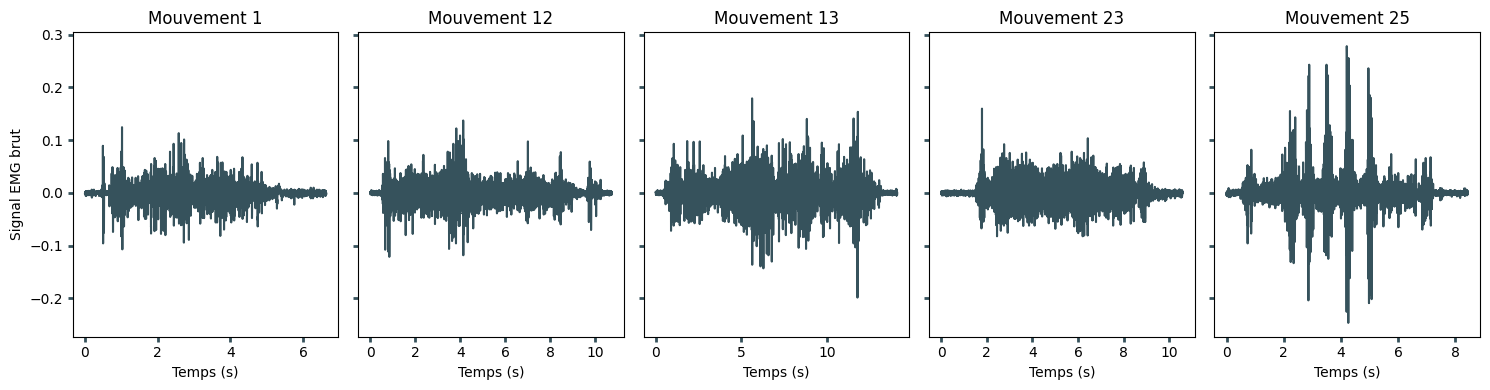

In [ ]:
subject = 15
channel = 1
adl_1 = 1
adl_2 = 12
adl_3 = 13
adl_4 = 23
adl_5 = 25

row_1 = raw_data.loc[(raw_data['subject'] == subject) & (raw_data['ADL'] == adl_1)]
time_1 = row_1['time'].values[0]
raw_emg_1 = row_1['raw_emg'].values[0][:, channel]

row_2 = raw_data.loc[(raw_data['subject'] == subject) & (raw_data['ADL'] == adl_2)]
time_2 = row_2['time'].values[0]
raw_emg_2 = row_2['raw_emg'].values[0][:, channel]

row_3 = raw_data.loc[(raw_data['subject'] == subject) & (raw_data['ADL'] == adl_3)]
time_3 = row_3['time'].values[0]
raw_emg_3 = row_3['raw_emg'].values[0][:, channel]

row_4 = raw_data.loc[(raw_data['subject'] == subject) & (raw_data['ADL'] == adl_4)]
time_4 = row_4['time'].values[0]
raw_emg_4 = row_4['raw_emg'].values[0][:, channel]

row_5 = raw_data.loc[(raw_data['subject'] == subject) & (raw_data['ADL'] == adl_5)]
time_5 = row_5['time'].values[0]
raw_emg_5 = row_5['raw_emg'].values[0][:, channel]


#plt.title(f'subject: {subject}, Muscle: {channel}, ADL: {adl}')


fig, ax = plt.subplots(1, 5, figsize=(15, 4),  sharey=True)

ax[0].plot(time_1, raw_emg_1, color='#36525C')
ax[1].plot(time_2, raw_emg_2, color='#36525C')
ax[2].plot(time_3, raw_emg_3, color='#36525C')
ax[3].plot(time_4, raw_emg_4, color='#36525C')
ax[4].plot(time_5, raw_emg_5, color='#36525C')


ax[0].tick_params(axis='both', which='both', color='#36525C', width=2)
ax[0].set_xlabel('Temps (s)')
ax[0].set_ylabel('Signal EMG brut')
ax[0].set_title('Mouvement 1')

ax[1].tick_params(axis='both', which='both', color='#36525C', width=2)
ax[1].set_xlabel('Temps (s)')
ax[1].set_title('Mouvement 12')


ax[2].tick_params(axis='both', which='both', color='#36525C', width=2)
ax[2].set_xlabel('Temps (s)')
ax[2].set_title('Mouvement 13')


ax[3].tick_params(axis='both', which='both', color='#36525C', width=2)
ax[3].set_xlabel('Temps (s)')
ax[3].set_title('Mouvement 23')


ax[4].tick_params(axis='both', which='both', color='#36525C', width=2)
ax[4].set_xlabel('Temps (s)')
ax[4].set_title('Mouvement 25')




plt.tight_layout()
#plt.show()

fig = plt.gcf()
fig.patch.set_alpha(0.0)
plt.savefig('/content/drive/MyDrive/projet_EMG/raw_examples.svg', format='svg', transparent=True)